In [1]:
import pandas as pd
import yaml
from matplotlib import pyplot as plt
from datetime import datetime as dt

config file

In [2]:
with open("..\\budget_book\config.ini", "r") as ymlfile:
    cfg = yaml.safe_load(ymlfile)

clm = cfg['column names database']

read historic stock prices

In [3]:
stockdata = pd.read_csv( 'stockdata.csv', encoding = 'ISO-8859-1' )

stockdata["Date"] = pd.to_datetime( stockdata["Date"] , format = '%Y-%m-%d' )
stockdata.set_index("Date", inplace=True)

stockdata.head()

,GOOG,IE00B57X3V84
Date,,
2023-01-02,NaN,NaN
2023-01-03,83.911250,48.886866
2023-01-04,84.014782,49.896393
2023-01-05,81.716371,48.980021
2023-01-06,83.689393,50.094003


1 year performance

In [4]:
(stockdata.iloc[-1] / stockdata[stockdata.index >= dt(dt.today().year - 1 , dt.today().month , dt.today().day)].iloc[0] - 1)*100

GOOG            14.314499
IE00B57X3V84     7.824650
dtype: float64

In [5]:
stocks = list(stockdata.columns)

read stock transactions

In [6]:
transactions = pd.read_csv( 'stock_transactions.csv', encoding = 'ISO-8859-1' )

transactions['date'] = pd.to_datetime( transactions['date'] , format = '%Y-%m-%d' )
transactions.set_index(clm["date"], inplace=True)

transactions.head(15)

,amount,description
date,,
2023-12-01,200.0,IE00B57X3V84
2023-11-01,200.0,IE00B57X3V84
2023-10-02,200.0,IE00B57X3V84
2023-09-01,200.0,IE00B57X3V84
2023-08-01,200.0,IE00B57X3V84
2023-07-03,200.0,IE00B57X3V84
2023-06-01,200.0,IE00B57X3V84
2023-05-01,200.0,IE00B57X3V84
2023-04-03,200.0,IE00B57X3V84


subtract fee

In [7]:
def fee(x):
    return x - 4.9

calculate total invested money & aquired shares

In [8]:
shares = transactions.join(stockdata).sort_index()

transactions_columns = [(column, ''       ) for column in transactions.columns]
share_columns        = [(stock , 'price €') for stock  in stocks              ]
shares.columns = pd.MultiIndex.from_tuples(transactions_columns + share_columns)

for stock in stocks:
    shares[(stock, 'invest €')] = shares[clm["text"]].str.contains(stock) * shares[clm["amount"]]
    shares[(stock, 'invest €')] = shares[(stock, 'invest €')].cumsum()

    shares[(stock, 'shares'  )] = shares[clm["text"]].str.contains(stock) * shares[clm["amount"]].map(fee) / shares[(stock, 'price €')]
    shares[(stock, 'shares'  )] = shares[(stock, 'shares')].cumsum()

shares.drop(share_columns + transactions_columns, axis = 1, inplace=True)

shares = shares.reindex(sorted(shares.columns), axis=1)

shares.tail(15)

GOOG           IE00B57X3V84           
           invest €    shares     invest €     shares
date                                                 
2023-01-03      0.0   0.00000        200.0   3.990847
2023-02-01      0.0   0.00000        400.0   7.792032
2023-03-01      0.0   0.00000        600.0  11.604045
2023-03-13   1000.0  11.61182        600.0  11.604045
2023-04-03   1000.0  11.61182        800.0  15.322039
2023-05-01   1000.0  11.61182       1000.0  19.074404
2023-06-01   1000.0  11.61182       1200.0  22.643125
2023-07-03   1000.0  11.61182       1400.0  26.150136
2023-08-01   1000.0  11.61182       1600.0  29.584792
2023-09-01   1000.0  11.61182       1800.0  33.029972
2023-10-02   1000.0  11.61182       2000.0  36.535249
2023-11-01   1000.0  11.61182       2200.0  40.102759
2023-12-01   1000.0  11.61182       2400.0  43.464633

filter time

In [9]:
# stockdata = stockdata[stockdata.index > dt(dt.today().year - 1 , dt.today().month , 1) ]
stockdata = stockdata[stockdata.index >= transactions.index[-1] ]

join stock prices & shares

In [10]:
stockdata.columns = pd.MultiIndex.from_tuples(share_columns)

data = stockdata.join(shares.resample('1D').mean(numeric_only=True).interpolate(method='pad')).interpolate(method='pad')

calculate value, profit, performance

In [11]:
for stock in stocks:
    data[(stock, 'value €') ] =  data[(stock, 'price €')] * data[(stock, 'shares')]
    data[(stock, 'profit €')] =  data[(stock, 'value €')] - data[(stock, 'invest €')]

data[('all', 'invest €') ] =  data.xs('invest €', axis=1, level=1).sum(axis=1)
data[('all', 'value €' ) ] =  data.xs('value €' , axis=1, level=1).sum(axis=1)
data[('all', 'profit €') ] =  data.xs('profit €', axis=1, level=1).sum(axis=1)

shares_columns = [(stock, 'shares') for stock  in stocks]
data.drop(share_columns + shares_columns, axis = 1, inplace=True)

data = data.reindex(sorted(data.columns), axis=1)

data.tail()

GOOG                          IE00B57X3V84              \
           invest €    profit €      value €     invest €    profit €   
Date                                                                    
2023-12-25   1000.0  501.767587  1501.767587       2400.0  176.825244   
2023-12-26   1000.0  503.154968  1503.154968       2400.0  186.256637   
2023-12-27   1000.0  485.562982  1485.562982       2400.0  188.864500   
2023-12-28   1000.0  475.115671  1475.115671       2400.0  177.482103   
2023-12-29   1000.0  476.839027  1476.839027       2400.0  190.436276   

                             all                           
                value € invest €    profit €      value €  
Date                                                       
2023-12-25  2576.825244   3400.0  678.592831  4078.592831  
2023-12-26  2586.256637   3400.0  689.411604  4089.411604  
2023-12-27  2588.864500   3400.0  674.427483  4074.427483  
2023-12-28  2577.482103   3400.0  652.597775  4052.597775  
2023-12-29  2590.436276   3400.0  667.275303  4067.275303

plot

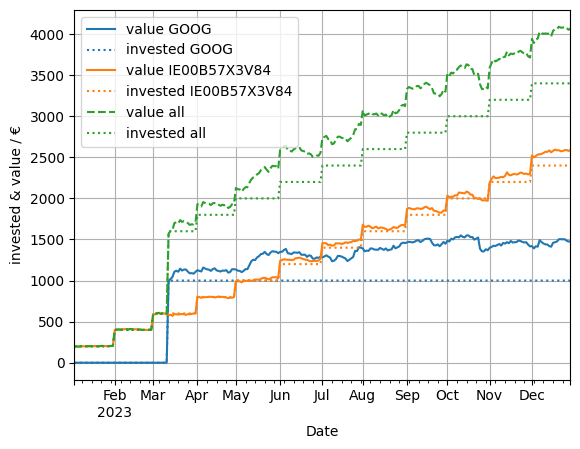

In [12]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig,ax = plt.subplots(1)
for i, stock in enumerate(stocks):
    data[(stock, 'value €') ].plot(label='value '    + stock, color=colors[i])
    data[(stock, 'invest €')].plot(label='invested ' + stock, color=colors[i]  , linestyle=':' )
data[('all', 'value €' )    ].plot(label='value all'   ,      color=colors[i+1], linestyle='--')
data[('all', 'invest €')    ].plot(label='invested all',      color=colors[i+1], linestyle=':' )
plt.grid()
plt.ylabel('invested & value / €')
plt.legend()
# ax.set_yticklabels([])

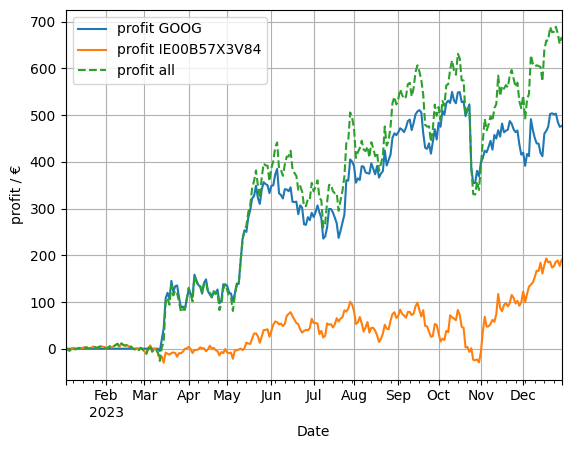

In [13]:
for stock in stocks:
    data[(stock, 'profit €')].plot(label='profit ' + stock)
data[('all', 'profit €')    ].plot(label='profit all', linestyle='--')
plt.grid()
plt.ylabel('profit / €')
plt.legend()